Importing modules

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import papermill as pm
import logging
from IPython.display import Image, display

Data Cleaning Pipeline

In [30]:
#insert data pipeline here

In [31]:
#I found this logger code online in github issue post, it works to suppress what I want
class PapermillFilter(logging.Filter):
    def filter(self, record):
        #suppress these annoying console logs
        return not ('Executing Cell' in record.getMessage() or 'Ending Cell' in record.getMessage())

# Apply the custom filter to papermill's logger
logger = logging.getLogger('papermill')
logger.setLevel(logging.INFO)  #Info level will show ipynb prints
handler = logging.StreamHandler()
handler.addFilter(PapermillFilter())  # Apply our filter
logger.addHandler(handler)

Preliminary data analysis: selecting the locations of interest
NB: This data contains the breweries and beers defined by country excluding the US which is further separated by US states

Input Notebook:  modules/1.ipynb
Input Notebook:  modules/1.ipynb
Output Notebook: modules/1.ipynb
Output Notebook: modules/1.ipynb


Executing notebook with kernel: python3
Executing notebook with kernel: python3
<Figure size 1200x800 with 2 Axes>
<Figure size 1200x800 with 2 Axes>


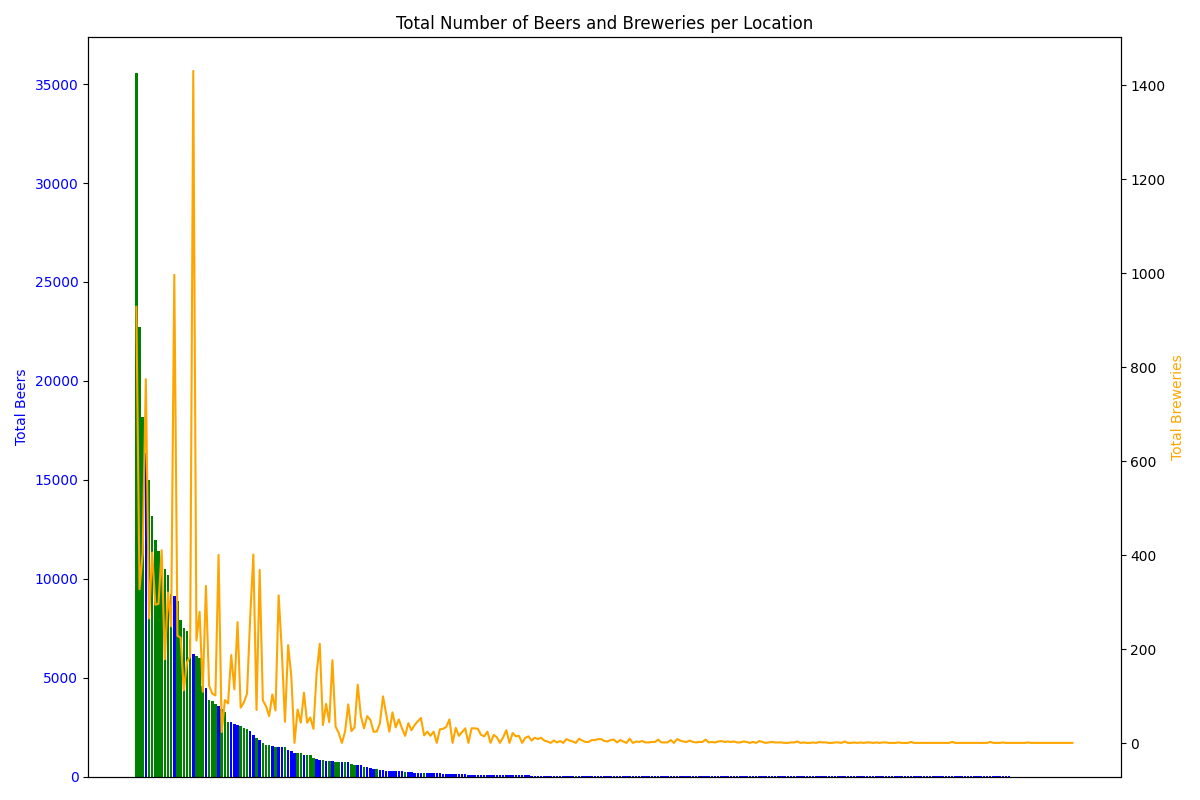

In [32]:
pm.execute_notebook(
        'modules/1.ipynb',
        'modules/1.ipynb', #dont want to make new file
        log_output=True,
        progress_bar=False,
        report_mode=True
    )

display(Image(filename='modules/1.png'))

The distribution of users by location of origin

Input Notebook:  modules/2.ipynb
Input Notebook:  modules/2.ipynb
Output Notebook: modules/2.ipynb
Output Notebook: modules/2.ipynb
Executing notebook with kernel: python3
Executing notebook with kernel: python3
Quick stats on the users
total number of users: 153704
Number of users with known locations: 122425
Users originate from:  194 different locations

Quick stats on the users
total number of users: 153704
Number of users with known locations: 122425
Users originate from:  194 different locations

<Figure size 1000x600 with 1 Axes>
<Figure size 1000x600 with 1 Axes>


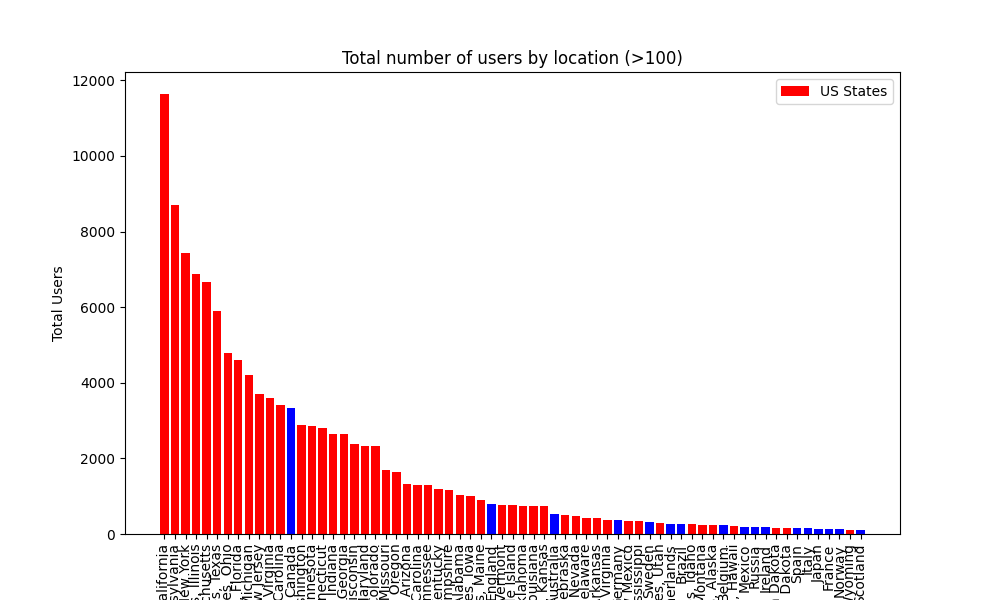

In [33]:
pm.execute_notebook(
        'modules/2.ipynb',
        'modules/2.ipynb', #dont want to make new file
        log_output=True,
        progress_bar=False,
        report_mode=True
    )

display(Image(filename='modules/2.png'))

Input Notebook:  modules/3.ipynb
Input Notebook:  modules/3.ipynb
Output Notebook: modules/3.ipynb
Output Notebook: modules/3.ipynb
Executing notebook with kernel: python3
Executing notebook with kernel: python3
<Figure size 1200x800 with 1 Axes>
<Figure size 1200x800 with 1 Axes>


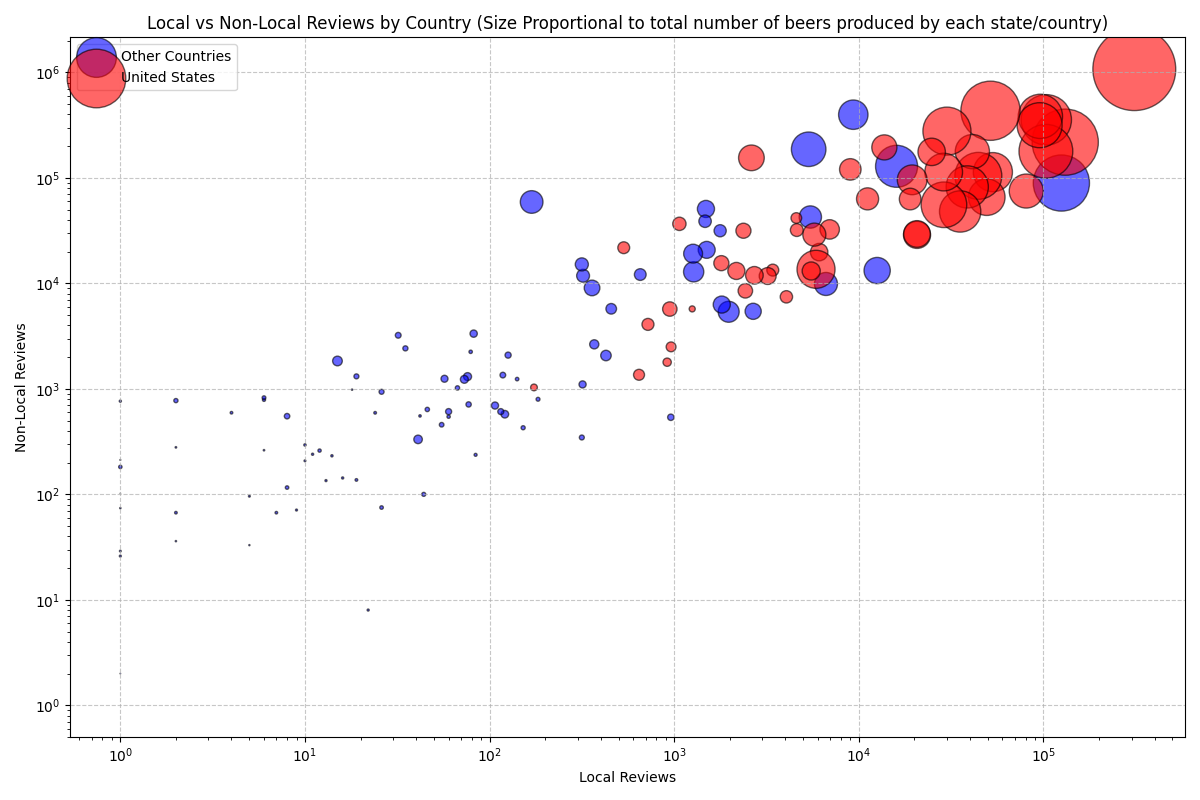

In [34]:
pm.execute_notebook(
        'modules/3.ipynb',
        'modules/3.ipynb', #dont want to make new file
        log_output=True,
        progress_bar=False,
        report_mode=True
    )

display(Image(filename='modules/3.png'))

The number of beers produced by each b